In [469]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Load CSV data

This walkthrough provides examples of how to use CSV data with TensorFlow.

There are two main parts to this:

1. **Loading the data off disk**
2. **Pre-processing it into a form suitable for training.**

We will work with data in memory, since the features set is quite small

Topics covered:
* Loading data from a csv
* splitting data into training, validation and test sets
* Handling mixed types of data
* Normalizing data
* Handling categorical features
* storing and re loading models




## Setup

In [470]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
#from sklearn import preprocessing



from sklearn.model_selection import train_test_split

## Basic preprocessing

In [471]:
#url="https://junwin.github.io/HouseData3.csv"
housePrices=pd.read_csv('/content/housepriceclean2.csv').sample(frac=1)
housePrices.pop('ClosedDate')
#housePrices.pop('YearBuilt')
housePrices.head()

#housePrices = pd.read_csv("https://storage.googleapis.com/tf-datasets/housePrices/train.csv")


,SoldPr,Type,Zip,Area,Rooms,FullBaths,HalfBaths,BsmtBth,Beds,BsmtBeds,GarageSpaces,houseEra
3668,456125.000000,SFH,60203,2349,9,2,0,No,3.0,0,1.0,19B
1989,727557.812500,SFH,60062,3222,12,3,1,Yes,4.0,0,2.0,19A
1167,229456.500000,SFH,60062,1068,5,1,0,No,2.0,0,1.0,19A
2266,364258.253906,SFH,60062,1775,6,2,0,No,2.0,0,2.0,19A
3480,430500.000000,SFH,60025,1372,8,3,0,No,3.0,1,2.0,19A


In [472]:
#housePrices = housePrices.loc[(housePrices['Zip'] == 60076) & (housePrices['Type'] == 'SFH')]

#Working with input data
There one feature worth exploring is the year the propert was built, here, I am experimenting with changing the year to a range of time.

In [473]:
# save a copy
#housePrices.to_csv('/content/housepriceclean2.csv', index=False) 

In [474]:
housePrices['Zip'] = housePrices['Zip'].astype(str) 
housePrices.dtypes


SoldPr          float64
Type             object
Zip              object
Area              int64
Rooms             int64
FullBaths         int64
HalfBaths         int64
BsmtBth          object
Beds            float64
BsmtBeds          int64
GarageSpaces    float64
houseEra         object
dtype: object

In [475]:
train, test = train_test_split(housePrices, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


5988 train examples
1498 validation examples
1872 test examples


In [476]:
housePrices_features = train.copy()
housePrices_labels = housePrices_features.pop('SoldPr')
housePrices_labels = housePrices_labels/100000

val_features = val.copy()
val_labels = val.pop('SoldPr')
val_labels = val_labels/100000

In [477]:
print(housePrices_features.dtypes)
print(housePrices_labels.dtypes)

Type             object
Zip              object
Area              int64
Rooms             int64
FullBaths         int64
HalfBaths         int64
BsmtBth          object
Beds            float64
BsmtBeds          int64
GarageSpaces    float64
houseEra         object
dtype: object
float64


Because of the different data types and ranges you can't simply stack the features into  NumPy array and pass it to a `keras.Sequential` model. Each column needs to be handled individually. 

As one option, you could preprocess your data offline (using any tool you like) to convert categorical columns to numeric columns, then pass the processed output to your TensorFlow model. The disadvantage to that approach is that if you save and export your model the preprocessing is not saved with it. The `experimental.preprocessing` layers avoid this problem because they're part of the model.


In this example, you'll build a model that implements the preprocessing logic using [Keras functional API](https://www.tensorflow.org/guide/keras/functional.ipynb). You could also do it by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

The functional API operates on "symbolic" tensors. Normal "eager" tensors have a value. In contrast these "symbolic" tensors do not. Instead they keep track of which operations are run on them, and build representation of the calculation, that you can run later. Here's a quick example:

To build the preprocessing model, start by building a set of symbolic `keras.Input` objects, matching the names and data-types of the CSV columns.

In [478]:
inputs = {}

for name, column in housePrices_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'Area': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Area')>,
 'Beds': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Beds')>,
 'BsmtBeds': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BsmtBeds')>,
 'BsmtBth': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'BsmtBth')>,
 'FullBaths': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'FullBaths')>,
 'GarageSpaces': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageSpaces')>,
 'HalfBaths': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'HalfBaths')>,
 'Rooms': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Rooms')>,
 'Type': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>,
 'Zip': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Zip')>,
 'houseEra': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'houseEra')>}

The first step in your preprocessing logic is to concatenate the numeric inputs together, and run them through a normalization layer:

In [479]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(housePrices[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization_16')>

Collect all the symbolic preprocessing results, to concatenate them later.

In [480]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the `preprocessing.StringLookup` function to map from strings to integer indices in a vocabulary. Next, use `preprocessing.CategoryEncoding` to convert the indexes into `float32` data appropriate for the model. 

The default settings for the `preprocessing.CategoryEncoding` layer create a one-hot vector for each input. A `layers.Embedding` would also work. See the [preprocessing layers guide](https://www.tensorflow.org/guide/keras/preprocessing_layers#quick_recipes) and [tutorial](../structured_data/preprocessing_layers.ipynb) for more on this topic.

In [481]:
zz=housePrices_features['Zip']
xxx = zz.to_numpy()
zz.unique()
#asd = ['SFH','Duplex','Condo', 'Townhouse']
#np.unique(xxx)
#rslt_df = housePrices_features[housePrices_features['Type'] in asd] 

array(['60025', '60026', '60076', '60062', '60202', '60077', '60002',
       '60053', '60091', '60201', '60203', '60625', '60029', '60626',
       '60035', '60067', '63104'], dtype=object)

In [482]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = preprocessing.StringLookup(vocabulary=np.unique(housePrices_features[name]))
  one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

With the collection of `inputs` and `processed_inputs`, you can concatenate all the preprocessed inputs together, and build a model that handles the preprocessing:

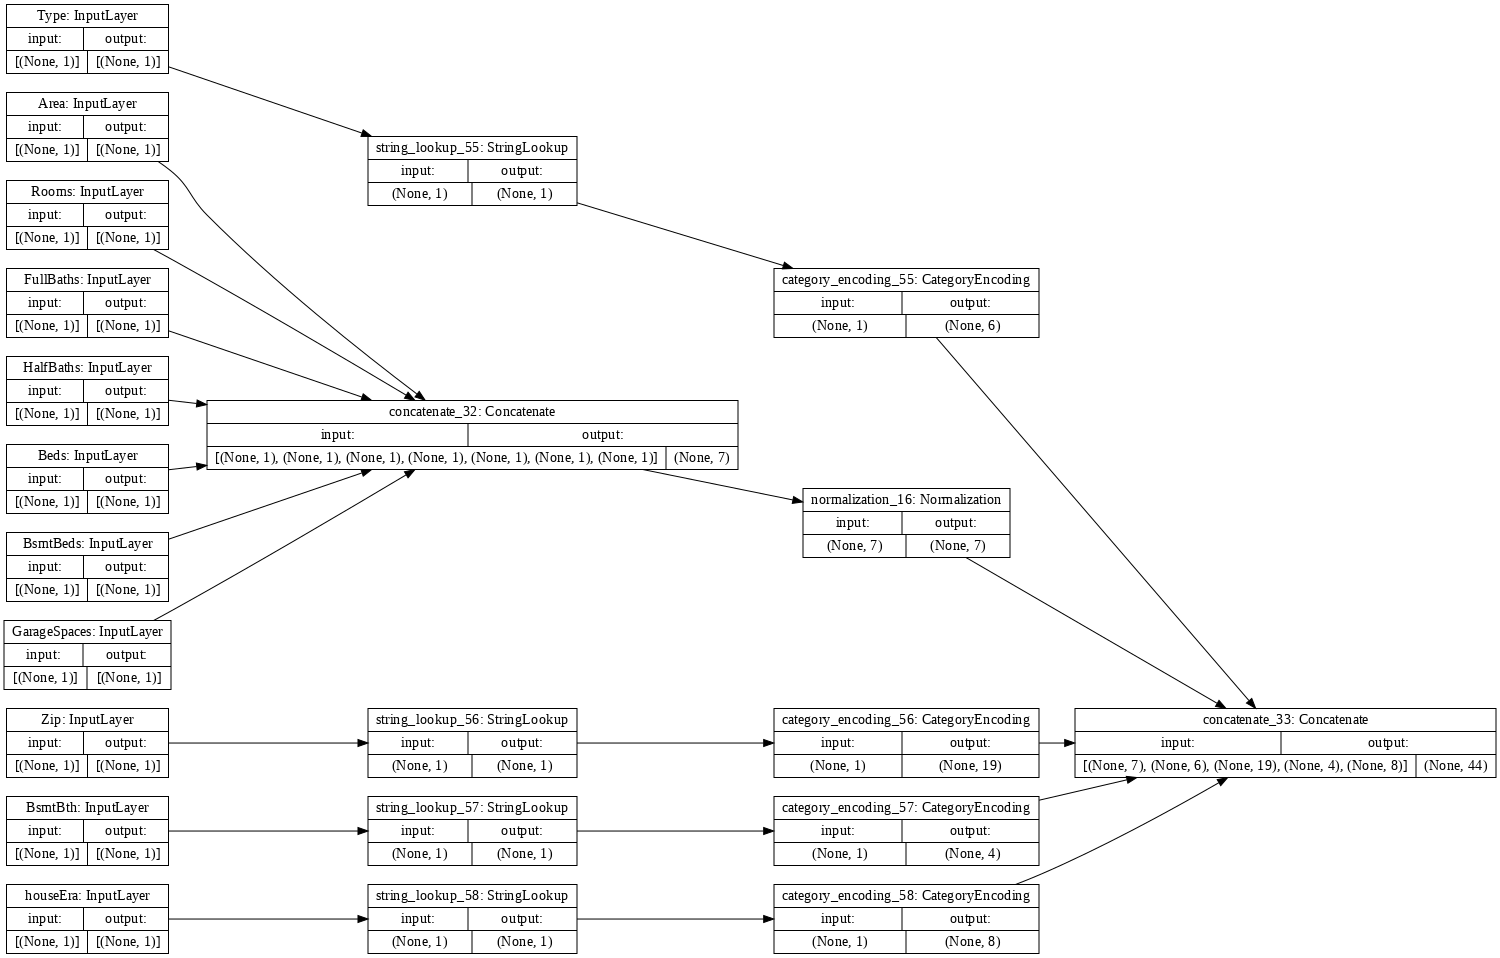

In [483]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

housePrices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = housePrices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

This `model` just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert Pandas `DataFrames` because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So convert it to a dictionary of tensors:

In [484]:
housePrices_features_dict = {name: np.array(value) 
                         for name, value in housePrices_features.items()}

Slice out the first training example and pass it to this preprocessing model, you see the numeric features and string one-hots all concatenated together:

In [485]:
features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}
housePrices_preprocessing(features_dict)

<tf.Tensor: shape=(1, 44), dtype=float32, numpy=
array([[-0.509, -0.399, -0.236, -0.959, -0.226, -0.374, -0.499,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]], dtype=float32)>

Now build the model on top of this:

In [486]:
def housePrices_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(32,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    #layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

housePrices_model = housePrices_model(housePrices_preprocessing, inputs)

When you train the model, pass the dictionary of features as `x`, and the label as `y`.

In [487]:
val_features_dict = {name: np.array(value) 
                         for name, value in val.items()}
history_1 = housePrices_model.fit(x=housePrices_features_dict, y=housePrices_labels,epochs=500,
                        validation_data=(val_features_dict, val_labels))

Epoch 1/500
188/188 [==============================] - 1s 4ms/step - loss: 13.3079 - mae: 2.4072 - val_loss: 2.2090 - val_mae: 0.9289
Epoch 2/500
188/188 [==============================] - 0s 3ms/step - loss: 2.0261 - mae: 0.8730 - val_loss: 1.9214 - val_mae: 0.8474
Epoch 3/500
188/188 [==============================] - 0s 3ms/step - loss: 1.9857 - mae: 0.8362 - val_loss: 1.9624 - val_mae: 0.8433
Epoch 4/500
188/188 [==============================] - 0s 2ms/step - loss: 1.8259 - mae: 0.8189 - val_loss: 1.8042 - val_mae: 0.8137
Epoch 5/500
188/188 [==============================] - 0s 3ms/step - loss: 1.8148 - mae: 0.8044 - val_loss: 1.7796 - val_mae: 0.7974
Epoch 6/500
188/188 [==============================] - 0s 3ms/step - loss: 1.5940 - mae: 0.7771 - val_loss: 1.7282 - val_mae: 0.7947
Epoch 7/500
188/188 [==============================] - 0s 2ms/step - loss: 1.5555 - mae: 0.7556 - val_loss: 1.7056 - val_mae: 0.7936
Epoch 8/500
188/188 [==============================] - 0s 3ms/step -

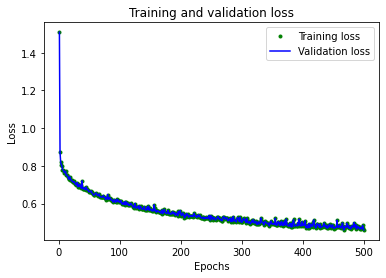

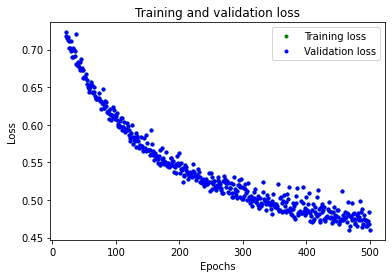

In [488]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
import matplotlib.pyplot as plt
train_loss = history_1.history['mae']
val_loss = history_1.history['mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Since the preprocessing is part of the model, you can save the model and reload it somewhere else and get identical results:

In [489]:
housePrices_model.save('test')
reloaded = tf.keras.models.load_model('test')

INFO:tensorflow:Assets written to: test/assets


In [490]:
features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}

before = housePrices_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[3.498]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.498]], shape=(1, 1), dtype=float32)


In [502]:


houseData_own2 = {'Type': np.array(['SFH', 'SFH', 'SFH', 'Condo', 'SFH']),
  'houseEra': np.array(['20A', '19A', '20A', '20A', '20A']),
	'Area': np.array([8410, 1400, 1500, 1500, 1500]),
  'Zip': np.array(['60062', '60062', '60076', '60076', '60076']),
	'Rooms': np.array([16, 6, 7, 7, 7]),
  'FullBaths': np.array([2.0, 2.0, 2.0, 2.5, 2.5]),
  'HalfBaths': np.array([0.0, 1.0, 1.0, 0.0, 0.0]),
  'BsmtBth': np.array(['Yes', 'No', 'No', 'No', 'No']),
  'Beds': np.array([5, 3, 3, 3, 3]),
  'BsmtBeds': np.array([1.0, 0.0, 0.0, 0.0, 0.0]),
  'GarageSpaces': np.array([3, 2, 0, 0, 0])  }

ans = reloaded.predict(houseData_own2)

print(ans)



[[10.503]
 [ 4.194]
 [ 3.242]
 [ 2.665]
 [ 3.586]]
